# CISC451/839 Final Project
## American Express - Default Prediction
#### Weizhi Quan (20091278) Jackson Cai (20099269) Ivy You (20164288)


### Data Compression

In [5]:
#Convert train and test dataset from .csv to .parquet due to extremely large size
import pandas as pd

train_data = pd.read_csv('./train_data.csv')
test_data = pd.read_csv('./test_data.csv')

In [ ]:
train_data.to_parquet('./train_data.parquet')
test_data.to_parquet('./test_data.parquet')

### Data Exploration & Visualization

In [1]:
#import and load dataset as pandas dataframe
import pandas as pd
import seaborn as sns
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

train_data_path = './train.parquet'
test_data_path = './test.parquet'
train_labels_path = './train_labels.csv'
train_data = pd.read_parquet(train_data_path)
test_data = pd.read_parquet(test_data_path)
train_labels_csv = pd.read_csv(train_labels_path)
train_labels_csv.to_parquet('./train_labels.parquet')
train_labels = pd.read_parquet('./train_labels.parquet')

/Users/quanweizhi/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [3]:
#join the train data with target labels  by customer ID
train_data_with_target = train_data.join(train_labels.set_index('customer_ID'), on='customer_ID')

In [4]:
#Train Dataset Size
train_data_with_target.shape

(5531451, 191)

In [9]:
#Train Dataset Glance
train_data_with_target.head()

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,target
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-03-09,0.938469,0,0.008724,1.006838,0.009228,0.124035,0.0,0.004709,...,-1,-1,0,0,0.0,NaN,0,0.000610,0,0
1,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-04-07,0.936665,0,0.004923,1.000653,0.006151,0.126750,0.0,0.002714,...,-1,-1,0,0,0.0,NaN,0,0.005492,0,0
2,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-05-28,0.954180,3,0.021655,1.009672,0.006815,0.123977,0.0,0.009423,...,-1,-1,0,0,0.0,NaN,0,0.006986,0,0
3,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-06-13,0.960384,0,0.013683,1.002700,0.001373,0.117169,0.0,0.005531,...,-1,-1,0,0,0.0,NaN,0,0.006527,0,0
4,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-07-16,0.947248,0,0.015193,1.000727,0.007605,0.117325,0.0,0.009312,...,-1,-1,0,0,0.0,NaN,0,0.008126,0,0


In [ ]:
#Train Dataset Statistics
train_data_with_target.describe()

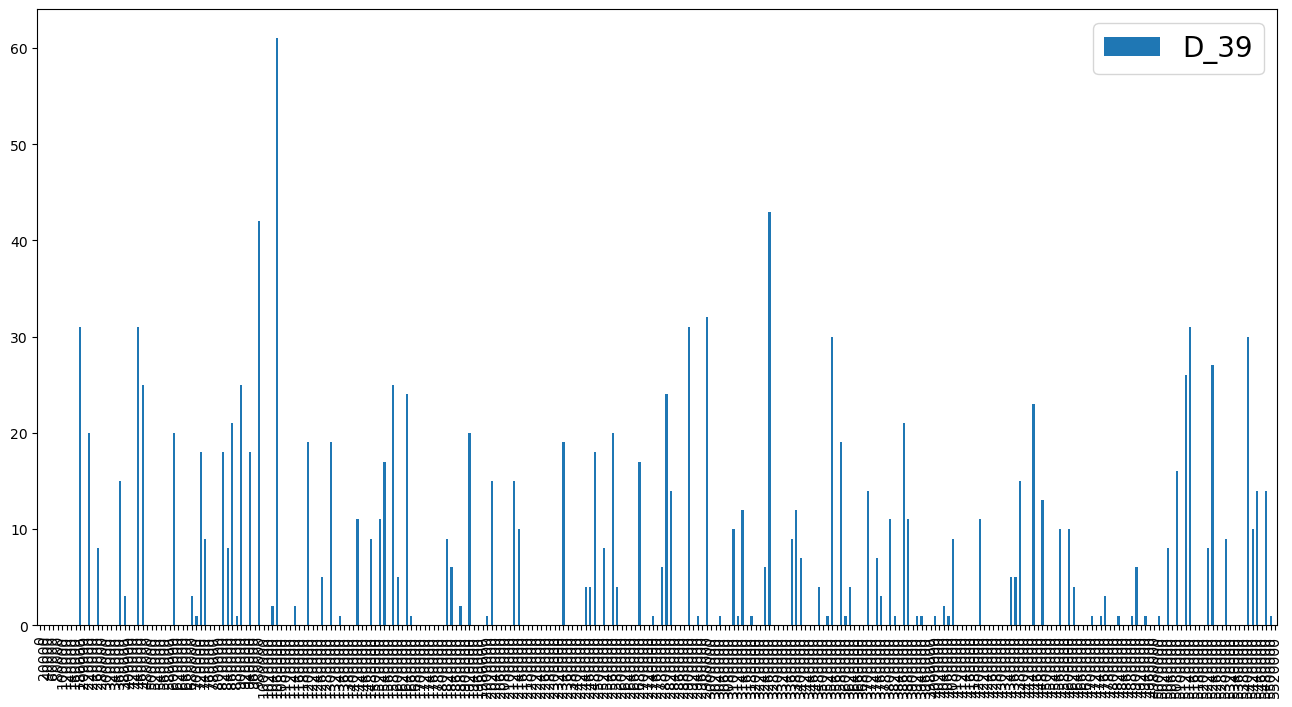

In [ ]:
#D_39 Variable Visualization
ax = train_data_with_target['D_39'][::20000].plot.bar(y='Delinquency variables',rot=90,figsize=(16,8),legend=True)
ax.legend (prop= {'size': 20})
plt.show()

In [ ]:
#check the data types
cat_features = ['B_30','B_38','D_114','D_116','D_117','D_120','D_126','D_63','D_64','D_66','D_68']
train_data_with_target[cat_features].dtypes

B_30     int8
B_38     int8
D_114    int8
D_116    int8
D_117    int8
D_120    int8
D_126    int8
D_63     int8
D_64     int8
D_66     int8
D_68     int8
dtype: object

In [ ]:
#Payment Variables Statistics
train_data_with_target[['P_2','P_3','P_4']].describe()

,P_2,P_3,P_4
count,5.485466e+06,5.229959e+06,5.531451e+06
mean,6.563343e-01,6.012886e-01,1.396476e-01
std,2.441398e-01,1.700240e-01,3.395976e-01
min,-4.589548e-01,-1.519690e+00,0.000000e+00
25%,4.803307e-01,5.408657e-01,0.000000e+00
50%,6.942950e-01,6.183025e-01,0.000000e+00
75%,8.648159e-01,6.838264e-01,0.000000e+00
max,1.010000e+00,2.428051e+00,1.269390e+00


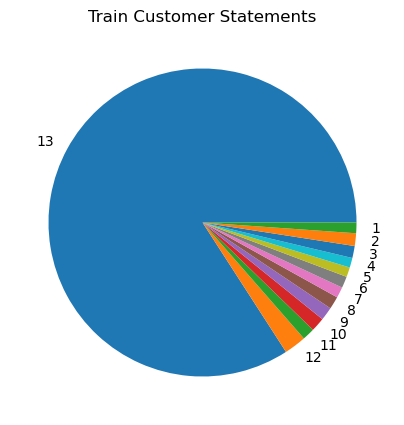

In [ ]:
#Target Distribution of Train Customer
fig, (ax1) = plt.subplots(1, figsize=(12, 5))
train_sc = train_data_with_target.customer_ID.value_counts().value_counts().sort_index(ascending=False).rename('Train Customer Statements')
ax1.pie(train_sc, labels=train_sc.index)
ax1.set_title(train_sc.name)
plt.show()

/var/folders/m7/hb6767ld4kn_vx12n4xly67r0000gn/T/ipykernel_79709/1942979534.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlations = train_data_with_target.corr().abs()


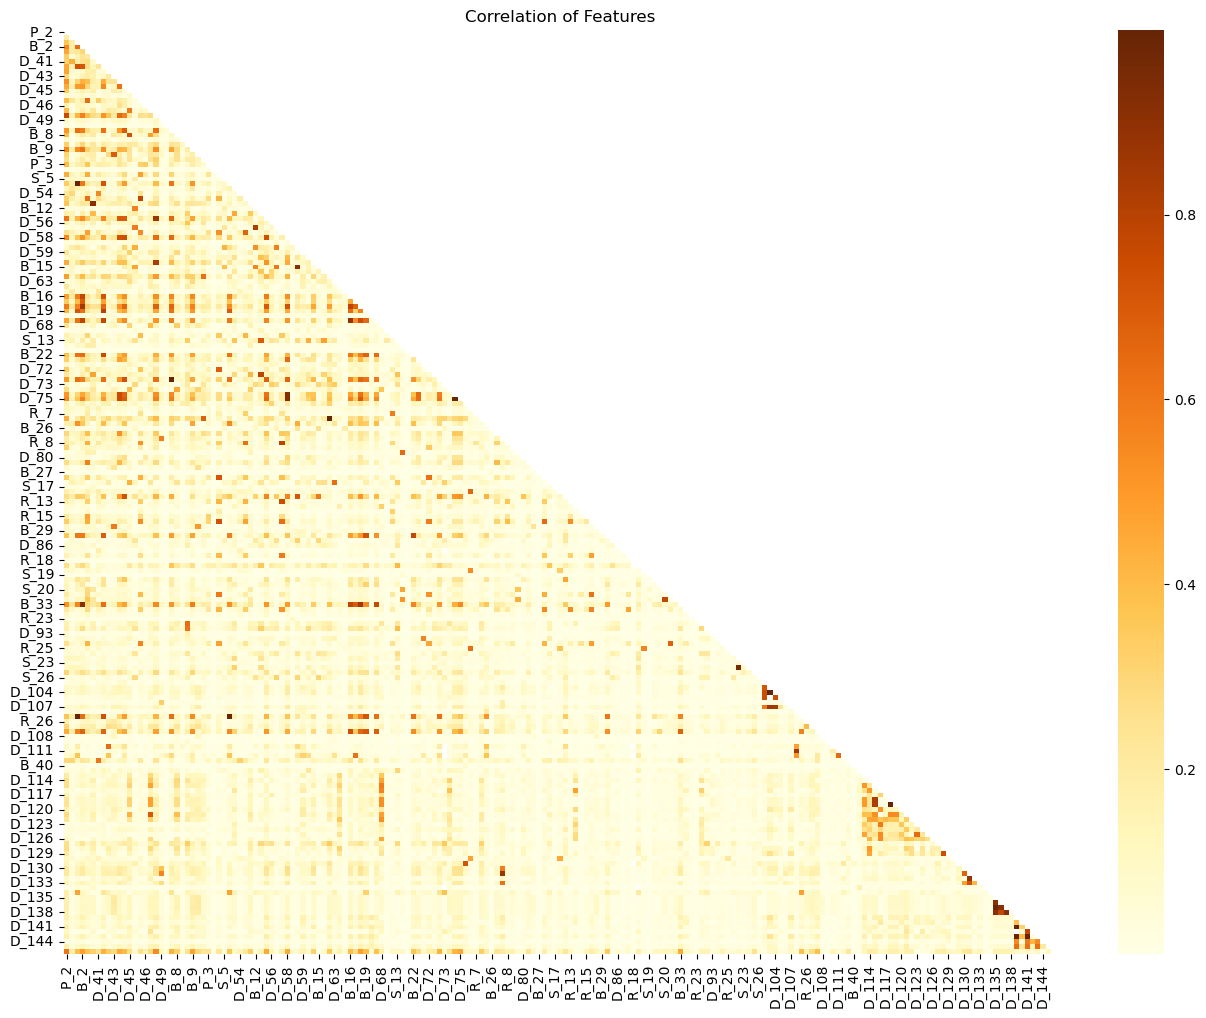

In [ ]:
#Correlation Heatmap
correlations = train_data_with_target.corr().abs()
mask=np.triu(np.ones_like(correlations))
fig, ax = plt.subplots(1,1, figsize=(16,12))
sns.heatmap(correlations, ax=ax, mask=mask, cmap='YlOrBr')
ax.set_title("Correlation of Features")
plt.show()

In [ ]:
#Sort by correlations
unstacked = correlations.unstack()
unstacked = unstacked.sort_values(ascending=False, kind="quicksort").drop_duplicates().head(25)
unstacked

P_2    P_2      1.000000
D_62   D_77     0.999780
D_103  D_104    0.999779
D_139  D_143    0.999623
       D_141    0.998245
D_141  D_143    0.997767
B_11   B_1      0.995574
B_23   B_7      0.995051
D_119  D_118    0.994915
B_37   B_1      0.992915
B_11   B_37     0.987941
D_74   D_75     0.987629
D_137  D_135    0.983801
S_22   S_24     0.959324
D_58   D_75     0.925965
       D_74     0.922826
D_138  D_137    0.919614
B_33   B_2      0.912829
B_15   B_14     0.909884
D_135  D_138    0.909463
D_137  D_136    0.908059
S_3    S_7      0.904635
D_135  D_136    0.903653
B_16   B_20     0.888546
D_132  D_131    0.880033
dtype: float64

In [ ]:
#Sort correlation with target column
correlation_target = train_data_with_target[train_data_with_target.columns[1:]].corr()['target'][:-1]
correlation_target = correlation_target.sort_values(key=abs, kind="quicksort").head(25)
correlation_target

/var/folders/m7/hb6767ld4kn_vx12n4xly67r0000gn/T/ipykernel_79709/2702076604.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_target = train_data_with_target[train_data_with_target.columns[1:]].corr()['target'][:-1]


D_134   -0.002199
D_123   -0.002862
B_27     0.003223
D_69     0.004504
D_144   -0.004526
R_18     0.004920
B_15     0.007371
S_12     0.007501
S_19     0.009651
S_18    -0.010023
B_40     0.014906
D_125    0.015457
R_23     0.016348
B_10    -0.018204
D_109   -0.018754
B_26     0.019853
D_102    0.019917
D_83     0.022926
S_27    -0.023457
R_28     0.027329
B_12    -0.027777
D_124    0.028097
B_13    -0.029443
S_17     0.030747
D_108    0.030781
Name: target, dtype: float64

In [ ]:
#Correlation between categorical columns
train_data_categorical = train_data_with_target[['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']]
from scipy.stats import chi2_contingency
def cramers_V(var1,var2) :
  crosstab =np.array(pd.crosstab(var1,var2, rownames=None, colnames=None))
  stat = chi2_contingency(crosstab)[0]
  obs = np.sum(crosstab)
  mini = min(crosstab.shape)-1
  return (stat/(obs*mini))

rows= []

for var1 in train_data_categorical:
  col = []
  for var2 in train_data_categorical:
    cramers =cramers_V(train_data_categorical[var1], train_data_categorical[var2])
    col.append(round(cramers,2))  
  rows.append(col)
  
cramers_results = np.array(rows)
correlation_categorical = pd.DataFrame(cramers_results, columns = train_data_categorical.columns, index = train_data_categorical.columns)
correlation_categorical

,B_30,B_38,D_114,D_116,D_117,D_120,D_126,D_63,D_64,D_66,D_68
B_30,1.00,0.47,0.01,0.01,0.01,0.01,0.00,0.01,0.01,0.00,0.01
B_38,0.47,1.00,0.04,0.03,0.01,0.05,0.02,0.02,0.02,0.00,0.01
D_114,0.01,0.04,1.00,0.50,0.51,0.50,0.36,0.00,0.45,0.00,0.41
D_116,0.01,0.03,0.50,1.00,0.50,0.50,0.34,0.00,0.35,0.00,0.38
D_117,0.01,0.01,0.51,0.50,1.00,0.50,0.23,0.00,0.20,0.00,0.11
D_120,0.01,0.05,0.50,0.50,0.50,1.00,0.34,0.00,0.35,0.00,0.39
D_126,0.00,0.02,0.36,0.34,0.23,0.34,1.00,0.00,0.17,0.00,0.21
D_63,0.01,0.02,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00
D_64,0.01,0.02,0.45,0.35,0.20,0.35,0.17,0.00,1.00,0.00,0.35
D_66,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.01


D_88      0.998915
D_110     0.994335
B_39      0.993920
D_73      0.989902
B_42      0.987078
            ...   
D_79      0.000000
R_8       0.000000
R_9       0.000000
S_16      0.000000
target    0.000000
Length: 191, dtype: float64

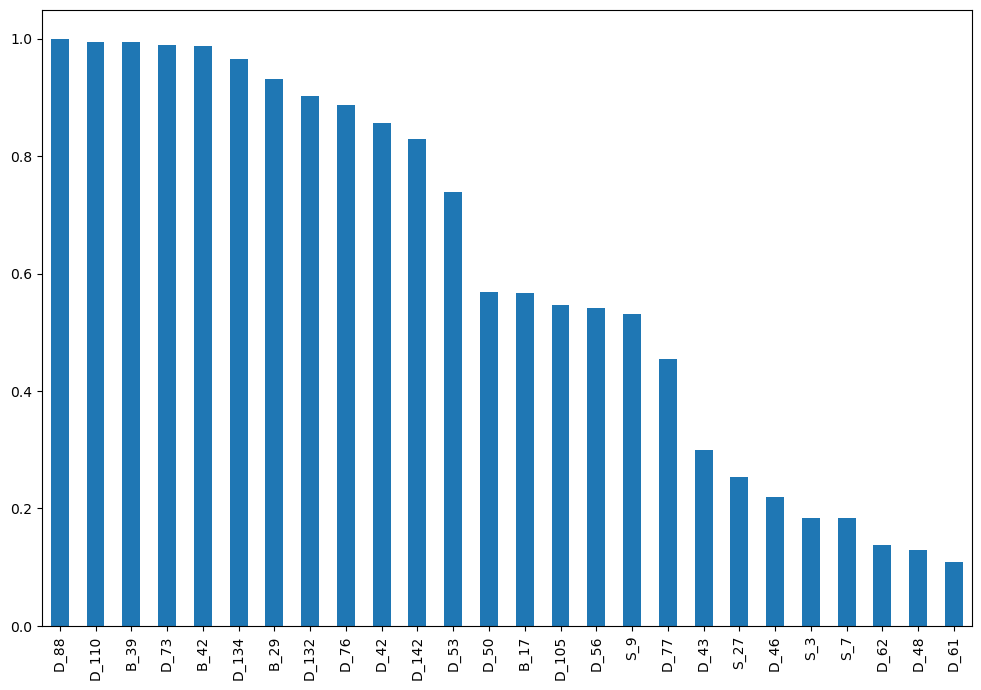

In [ ]:
#Null value visualization
nullVal = train_data_with_target.isnull().sum().sort_values(ascending=False)/len(train_data)
ax = nullVal[nullVal>0.1].plot.bar(x = 'Attribute',y='NullVal',rot=90,figsize=(12,8))
nullVal

In [ ]:
#Duplicate rows visualization
duplicateRows = train_data_with_target[train_data_with_target.duplicated()]
duplicateRows

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,target


In [ ]:
#Numeric & Categorical data
features_numeric = list(set(train_data_with_target.select_dtypes(include=['float32','int16','int8']))-set(['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68','S_2', 'customer_ID','target']))
features_categorical = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68','S_2']
print('numeric feature:' ,len(features_numeric), ';categorical feature:' , len(features_categorical))

NameError: name 'train_data_with_target' is not defined

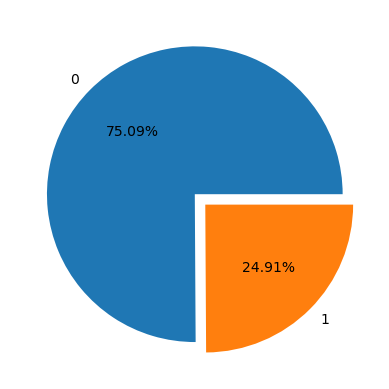

In [ ]:
#Distribution of target
pietarget = train_data_with_target['target'].value_counts()
labels = [0, 1]
explode = [0, 0.1]
plt.pie(pietarget, labels = labels, explode = explode, autopct = '%1.2f%%')
plt.show()

### Preprocessing

In [5]:
#Drop any column with missing value over 80%
train_data_missing = train_data_with_target.drop(['D_88','D_110','B_39','D_73','B_42','D_134','B_29','D_132','D_76','D_42','D_142'], axis = 1)
test_data_missing = test_data.drop(['D_88','D_110','B_39','D_73','B_42','D_134','B_29','D_132','D_76','D_42','D_142'], axis = 1)

In [ ]:
train_data_missing

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_136,D_137,D_138,D_139,D_140,D_141,D_143,D_144,D_145,target
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-03-09,0.938469,0,0.008724,1.006838,0.009228,0.124035,0.0,0.004709,...,-1,-1,-1,0,0,0.0,0,0.000610,0,0
1,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-04-07,0.936665,0,0.004923,1.000653,0.006151,0.126750,0.0,0.002714,...,-1,-1,-1,0,0,0.0,0,0.005492,0,0
2,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-05-28,0.954180,3,0.021655,1.009672,0.006815,0.123977,0.0,0.009423,...,-1,-1,-1,0,0,0.0,0,0.006986,0,0
3,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-06-13,0.960384,0,0.013683,1.002700,0.001373,0.117169,0.0,0.005531,...,-1,-1,-1,0,0,0.0,0,0.006527,0,0
4,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-07-16,0.947248,0,0.015193,1.000727,0.007605,0.117325,0.0,0.009312,...,-1,-1,-1,0,0,0.0,0,0.008126,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5531446,fffff1d38b785cef84adeace64f8f83db3a0c31e8d92ea...,2017-11-05,0.979333,14,0.020818,0.828199,0.003487,0.090743,0.0,0.025139,...,-1,-1,-1,0,0,0.0,0,0.001498,0,0
5531447,fffff1d38b785cef84adeace64f8f83db3a0c31e8d92ea...,2017-12-23,0.984907,10,0.007209,0.812610,0.005904,0.079886,0.0,0.023691,...,-1,-1,-1,0,0,0.0,0,0.008225,0,0
5531448,fffff1d38b785cef84adeace64f8f83db3a0c31e8d92ea...,2018-01-06,0.983019,15,0.013151,0.815422,0.003457,0.100503,0.0,0.012343,...,-1,-1,-1,0,0,0.0,0,0.006773,0,0
5531449,fffff1d38b785cef84adeace64f8f83db3a0c31e8d92ea...,2018-02-06,0.969861,15,0.009855,1.003541,0.005117,0.101802,0.0,0.008578,...,-1,-1,-1,0,0,0.0,0,0.001168,0,0


In [6]:
#Drop columns with high correlation (>95%) with other columns
train_data_correlation = train_data_missing.drop(['D_77','D_104','B_1','D_143','D_141','B_7','D_118','B_37','D_135','S_24'], axis = 1)
test_data_correlation = test_data_missing.drop(['D_77','D_104','B_1','D_143','D_141','B_7','D_118','B_37','D_135','S_24'], axis = 1)

In [ ]:
train_data_correlation

,customer_ID,S_2,P_2,D_39,B_2,R_1,S_3,D_41,B_3,D_43,...,D_133,R_28,D_136,D_137,D_138,D_139,D_140,D_144,D_145,target
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-03-09,0.938469,0,1.006838,0.009228,0.124035,0.0,0.004709,NaN,...,0.004345,0,-1,-1,-1,0,0,0.000610,0,0
1,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-04-07,0.936665,0,1.000653,0.006151,0.126750,0.0,0.002714,NaN,...,0.007495,0,-1,-1,-1,0,0,0.005492,0,0
2,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-05-28,0.954180,3,1.009672,0.006815,0.123977,0.0,0.009423,NaN,...,0.009227,0,-1,-1,-1,0,0,0.006986,0,0
3,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-06-13,0.960384,0,1.002700,0.001373,0.117169,0.0,0.005531,NaN,...,0.007206,0,-1,-1,-1,0,0,0.006527,0,0
4,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-07-16,0.947248,0,1.000727,0.007605,0.117325,0.0,0.009312,NaN,...,0.006312,0,-1,-1,-1,0,0,0.008126,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5531446,fffff1d38b785cef84adeace64f8f83db3a0c31e8d92ea...,2017-11-05,0.979333,14,0.828199,0.003487,0.090743,0.0,0.025139,0.014225,...,0.000776,0,-1,-1,-1,0,0,0.001498,0,0
5531447,fffff1d38b785cef84adeace64f8f83db3a0c31e8d92ea...,2017-12-23,0.984907,10,0.812610,0.005904,0.079886,0.0,0.023691,0.009467,...,0.001741,0,-1,-1,-1,0,0,0.008225,0,0
5531448,fffff1d38b785cef84adeace64f8f83db3a0c31e8d92ea...,2018-01-06,0.983019,15,0.815422,0.003457,0.100503,0.0,0.012343,0.006591,...,0.006060,0,-1,-1,-1,0,0,0.006773,0,0
5531449,fffff1d38b785cef84adeace64f8f83db3a0c31e8d92ea...,2018-02-06,0.969861,15,1.003541,0.005117,0.101802,0.0,0.008578,0.014235,...,0.003811,0,-1,-1,-1,0,0,0.001168,0,0


In [7]:
#Transform categorical data into numerical data by LabelEncoder
from sklearn.preprocessing import LabelEncoder
cat_features = ['B_30','B_38','D_114','D_116','D_117','D_120','D_126','D_63','D_64','D_66','D_68']
for cat_col in cat_features:
    encoder = LabelEncoder()
    train_data_correlation[cat_col] = encoder.fit_transform(train_data_correlation[cat_col])
    test_data_correlation[cat_col] = encoder.transform(test_data_correlation[cat_col])

In [ ]:
train_data_correlation[['B_30','B_38','D_114','D_116','D_117','D_120','D_126','D_63','D_64','D_66','D_68']].dtypes

B_30     int64
B_38     int64
D_114    int64
D_116    int64
D_117    int64
D_120    int64
D_126    int64
D_63     int64
D_64     int64
D_66     int64
D_68     int64
dtype: object

In [34]:
#Preprocessed data distribution
features_numeric = list(set(train_data_correlation.select_dtypes(include=['float32','int16','int8']))-set(['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68','S_2', 'customer_ID','target']))
features_categorical = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']
print('numeric feature:' ,len(features_numeric), ';categorical feature:' , len(set(features_categorical)))

numeric feature: 156 ;categorical feature: 11


In [ ]:
test_data_correlation.shape

(11363762, 169)

In [18]:
#convert to the new parquet
train_data_correlation.to_parquet('./train_corr.parquet')
test_data_correlation.to_parquet('./test_corr.parquet')

In [39]:
#then read the new parquet
train_data_correlation = pd.read_parquet('./train_corr.parquet')
test_data_correlation = pd.read_parquet('./test_corr.parquet')

### Feature Engineering

In [40]:
import gc
import warnings
import time
import progressbar
warnings.simplefilter(action='ignore', category=FutureWarning)
    
#feature generation (MAD) for train dataset
train = train_data_correlation.drop(['target'], axis = 1)
import pandas
def feature_engineering_MAD():
    for i in features_numeric:
        print('Starting training feature engineering for feature ' + i)
        train_num_agg_i = train.groupby("customer_ID")[i].agg(['mad'])
        train_num_agg_i.columns = [i + '_mad']
        # Save files to disk
        train_num_agg_i.to_parquet('./MAD/train_process_mad_' + i +'.parquet')

In [86]:
#feature generation (MAD) for test dataset
test = test_data_correlation
def feature_engineering_MAD_test():
    for i in features_numeric:
        print('Starting testing feature engineering for feature ' + i)
        test_num_agg_i = test.groupby("customer_ID")[i].agg(['mad'])
        test_num_agg_i.columns = [i + '_mad']
        # Save files to disk
        test_num_agg_i.to_parquet('./MAD_test/test_process_mad_' + i +'.parquet')

In [32]:
feature_engineering_MAD()

Starting training feature engineering for feature P_2
Starting training feature engineering for feature D_39
Starting training feature engineering for feature B_2
Starting training feature engineering for feature R_1
Starting training feature engineering for feature S_3
Starting training feature engineering for feature D_41
Starting training feature engineering for feature B_3
Starting training feature engineering for feature D_43
Starting training feature engineering for feature D_44
Starting training feature engineering for feature B_4
Starting training feature engineering for feature D_45
Starting training feature engineering for feature B_5
Starting training feature engineering for feature R_2
Starting training feature engineering for feature D_46
Starting training feature engineering for feature D_47
Starting training feature engineering for feature D_48
Starting training feature engineering for feature D_49
Starting training feature engineering for feature B_6
Starting training f

Starting training feature engineering for feature D_136
Starting training feature engineering for feature D_137
Starting training feature engineering for feature D_138
Starting training feature engineering for feature D_139
Starting training feature engineering for feature D_140
Starting training feature engineering for feature D_144
Starting training feature engineering for feature D_145


In [87]:
feature_engineering_MAD_test()

Starting testing feature engineering for feature R_12
Starting testing feature engineering for feature B_32
Starting testing feature engineering for feature D_139
Starting testing feature engineering for feature D_78
Starting testing feature engineering for feature D_53
Starting testing feature engineering for feature D_54
Starting testing feature engineering for feature B_36
Starting testing feature engineering for feature B_6
Starting testing feature engineering for feature S_7
Starting testing feature engineering for feature D_69
Starting testing feature engineering for feature D_133
Starting testing feature engineering for feature S_17
Starting testing feature engineering for feature R_17
Starting testing feature engineering for feature B_21
Starting testing feature engineering for feature D_115
Starting testing feature engineering for feature R_8
Starting testing feature engineering for feature D_60
Starting testing feature engineering for feature D_56
Starting testing feature eng

Starting testing feature engineering for feature R_14
Starting testing feature engineering for feature R_21
Starting testing feature engineering for feature B_40
Starting testing feature engineering for feature B_25


In [89]:
#join all MAD files
train_process0 = train_data_correlation['customer_ID'].unique()
train_process0 = pd.DataFrame(train_process0, columns = ['customer_ID'])
for i in features_numeric:
    train_cache = pd.read_parquet('./MAD/train_process_mad_' + i + '.parquet')
    train_process0 = train_process0.join(train_cache, on='customer_ID')
train_process0.to_parquet('./train_proceess0.parquet')

test_process0 = test_data_correlation['customer_ID'].unique()
test_process0 = pd.DataFrame(test_process0, columns = ['customer_ID'])
for i in features_numeric:
    test_cache = pd.read_parquet('./MAD_test/test_process_mad_' + i + '.parquet')
    test_process0 = test_process0.join(test_cache, on='customer_ID')
test_process0.to_parquet('./test_proceess0.parquet')

In [90]:
#Feature generation of all others
def feature_engineering():
    print('Starting training feature engineering...')
    #get the 'first','last','mean', 'std', 'min', 'max' and aggregate them as new columns
    train_num_agg = train.groupby("customer_ID")[features_numeric].agg(['first','last','mean', 'std', 'min', 'max'])
    train_num_agg.columns = ['_'.join(x) for x in train_num_agg.columns]
    train_num_agg.reset_index(inplace = True)
    for col in features:
        if 'last' in col and col.replace('last', 'first') in train_num_agg:
            train_num_agg[col + '_lag_sub'] = train_num_agg[col] - train_num_agg[col.replace('last', 'first')]
    #get the 'count', 'last', 'nunique' and aggregate them as new columns  
    train_cat_agg = train.groupby("customer_ID")[features_categorical].agg(['count', 'last', 'nunique'])
    train_cat_agg.columns = ['_'.join(x) for x in train_cat_agg.columns]
    train_cat_agg.reset_index(inplace = True)
    train_process1 = train_num_agg.merge(train_cat_agg, how = 'inner', on = 'customer_ID').merge(train_labels, how = 'inner', on = 'customer_ID')
    gc.collect()
    
    print('Starting test feature engineering...')
    #get the 'first','last','mean', 'std', 'min', 'max' and aggregate them as new columns 
    test_num_agg = test.groupby("customer_ID")[features_numeric].agg(['first','last','mean', 'std', 'min', 'max'])
    test_num_agg.columns = ['_'.join(x) for x in test_num_agg.columns]
    test_num_agg.reset_index(inplace = True)
    for col in features:
        if 'last' in col and col.replace('last', 'first') in test_num_agg:
            test_num_agg[col + '_lag_sub'] = test_num_agg[col] - test_num_agg[col.replace('last', 'first')]
    #get the 'count', 'last', 'nunique' and aggregate them as new columns  
    test_cat_agg = test.groupby("customer_ID")[features_categorical].agg(['count', 'last', 'nunique'])
    test_cat_agg.columns = ['_'.join(x) for x in test_cat_agg.columns]
    test_cat_agg.reset_index(inplace = True)
    test_process1 = test_num_agg.merge(test_cat_agg, how = 'inner', on = 'customer_ID')
    del test_num_agg, test_cat_agg
    gc.collect()
    # Save files to disk
    train_process1.to_parquet('./train_process_1.parquet')
    test_process1.to_parquet('./test_process_1.parquet')

In [91]:
#start feature engineering here
feature_engineering()

Starting training feature engineering...
Starting test feature engineering...


In [113]:
#read the parquet
train_process0 = pd.read_parquet('./train_proceess0.parquet')
test_process0 = pd.read_parquet('./test_proceess0.parquet')
train_process1 = pd.read_parquet('./train_process_1.parquet')
test_process1 = pd.read_parquet('./test_process_1.parquet')
#convert all data types to float type
for i in train_process0.columns:
    if i != 'customer_ID':
        train_process0[i] = train_process0[i].astype(float)

for i in test_process0.columns:
    if i != 'customer_ID':
        test_process0[i] = test_process0[i].astype(float)
        
for i in train_process1.columns:
    if i != 'customer_ID':
        train_process1[i] = train_process1[i].astype(float)

for i in test_process1.columns:
    if i != 'customer_ID':
        test_process1[i] = test_process1[i].astype(float)

In [117]:
#check the types
train_process1.dtypes

customer_ID      object
R_12_first      float64
R_12_last       float64
R_12_mean       float64
R_12_std        float64
                 ...   
D_66_nunique    float64
D_68_count      float64
D_68_last       float64
D_68_nunique    float64
target          float64
Length: 971, dtype: object

In [118]:
#Merge all feature generation steps and write
train_processed = train_process0.merge(train_process1, on='customer_ID')
test_processed = test_process0.merge(test_process1, on='customer_ID')
train_processed.to_parquet('./train_processed.parquet')
test_processed.to_parquet('./test_processed.parquet')

In [119]:
train_processed.head()

,customer_ID,R_12_first,R_12_last,R_12_mean,R_12_std,R_12_min,R_12_max,B_32_first,B_32_last,B_32_mean,...,D_129_mad,D_122_mad,D_80_mad,R_25_mad,B_11_mad,S_13_mad,R_14_mad,R_21_mad,B_40_mad,B_25_mad
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.00000,0.473373,0.0,0.002553,136.757396,0.0,0.0,0.063680,0.002814
1,00000fd6641609c6ece5454664794f0340ad84dddce9a2...,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.00000,0.000000,0.0,0.011213,156.153846,0.0,0.0,0.005817,0.015435
2,00001b22f846c82c51f6e3958ccd81970162bae8b007e8...,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.00000,0.000000,0.0,0.001826,0.000000,0.0,0.0,0.010110,0.002188
3,000041bdba6ecadd89a52d11886e8eaaec9325906c9723...,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.35503,0.000000,0.0,0.047351,0.000000,0.0,0.0,0.080876,0.038079
4,00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8a...,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.00000,0.461538,0.0,0.003368,0.000000,0.0,0.0,0.043541,0.002220


### Feature Selection

In [2]:
#Read data
train_processed = pd.read_parquet('./train_processed.parquet')
test_processed = pd.read_parquet('./test_processed.parquet')

In [3]:
test_processed.shape

(924621, 1126)

In [4]:
test_processed.head(5)

,customer_ID,R_12_mad,B_32_mad,D_139_mad,D_78_mad,D_53_mad,D_54_mad,B_36_mad,B_6_mad,S_7_mad,...,D_63_nunique,D_64_count,D_64_last,D_64_nunique,D_66_count,D_66_last,D_66_nunique,D_68_count,D_68_last,D_68_nunique
0,00000469ba478561f23a92a868bd366de6f6527a684c9a...,0.0,0.0,0.197531,0.000000,NaN,0.0,0.003467,0.266444,0.024226,...,1.0,9.0,4.0,2.0,9.0,0.0,1.0,9.0,7.0,2.0
1,00001bf2e77ff879fab36aa4fac689b9ba411dae63ae39...,0.0,0.0,0.000000,0.000000,NaN,0.0,0.002743,0.007127,0.025696,...,1.0,13.0,1.0,1.0,13.0,0.0,1.0,13.0,7.0,1.0
2,0000210045da4f81e5f122c6bde5c2a617d03eef67f82c...,0.0,0.0,0.000000,0.000000,NaN,0.0,0.002194,0.057422,0.037390,...,1.0,13.0,4.0,2.0,13.0,2.0,1.0,13.0,5.0,2.0
3,00003b41e58ede33b8daf61ab56d9952f17c9ad1c3976c...,0.0,0.0,0.000000,0.000000,NaN,0.0,0.002287,0.003820,0.035570,...,1.0,13.0,3.0,1.0,13.0,0.0,1.0,13.0,6.0,1.0
4,00004b22eaeeeb0ec976890c1d9bfc14fd9427e98c4ee9...,0.0,0.0,0.000000,0.532544,NaN,0.0,0.002415,0.004162,0.016175,...,1.0,13.0,3.0,2.0,13.0,0.0,1.0,13.0,6.0,2.0


In [3]:
import os
import gc
import warnings
warnings.filterwarnings('ignore')
import random
import scipy as sp
import numpy as np
import pandas as pd
import joblib
import itertools
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from tqdm.auto import tqdm
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
from itertools import combinations
#define the path, seed, number of folds, and target
class CFG:
    input_dir = '/Users/quanweizhi/Desktop/amex-default-prediction'
    seed = 42
    n_folds = 5
    target = 'target'
# ====================================================
# Seed everything
# ====================================================
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

# Lightgbm

In [4]:
#amex metric is given by American Express to evaluate our model performance
def amex_metric(y_true, y_pred):
    labels = np.transpose(np.array([y_true, y_pred]))
    labels = labels[labels[:, 1].argsort()[::-1]]
    weights = np.where(labels[:,0]==0, 20, 1)
    cut_vals = labels[np.cumsum(weights) <= int(0.04 * np.sum(weights))]
    top_four = np.sum(cut_vals[:,0]) / np.sum(labels[:,0])
    gini = [0,0]
    for i in [1,0]:
        labels = np.transpose(np.array([y_true, y_pred]))
        labels = labels[labels[:, i].argsort()[::-1]]
        weight = np.where(labels[:,0]==0, 20, 1)
        weight_random = np.cumsum(weight / np.sum(weight))
        total_pos = np.sum(labels[:, 0] *  weight)
        cum_pos_found = np.cumsum(labels[:, 0] * weight)
        lorentz = cum_pos_found / total_pos
        gini[i] = np.sum((lorentz - weight_random) * weight)
    return 0.5 * (gini[1]/gini[0] + top_four)

# ====================================================
# LGBM amex metric
# ====================================================
def lgb_amex_metric(y_pred, y_true):
    y_true = y_true.get_label()
    return 'amex_metric', amex_metric(y_true, y_pred), True

# ====================================================
# Train & Evaluate
# ====================================================
importances = []
def train_and_evaluate(train, test):
    # Label encode categorical features
    cat_features = ["B_30","B_38","D_114","D_116","D_117","D_120","D_126","D_63","D_64","D_66","D_68"]
    cat_features = [f"{cf}_last" for cf in cat_features]
    for cat_col in cat_features:
        encoder = LabelEncoder()
        train[cat_col] = encoder.fit_transform(train[cat_col])
        test[cat_col] = encoder.transform(test[cat_col])
    # Round last float features to 2 decimal place
    num_cols = list(train.dtypes[(train.dtypes == 'float32') | (train.dtypes == 'float64')].index)
    num_cols = [col for col in num_cols if 'last' in col]
    for col in num_cols:
        train[col + '_round2'] = train[col].round(2)
        test[col + '_round2'] = test[col].round(2)
    # Get feature list
    features = [col for col in train.columns if col not in ['customer_ID', CFG.target]]
    #set the parameters
    params = {
        'objective': 'binary',
        'metric': "binary_logloss",
        'boosting': 'dart',
        'seed': CFG.seed,
        'num_leaves': 100,
        'learning_rate': 0.01,
        'feature_fraction': 0.20,
        'bagging_freq': 10,
        'bagging_fraction': 0.50,
        'n_jobs': -1,
        'lambda_l2': 2,
        'min_data_in_leaf': 40
        }
    # Create a numpy array to store test predictions
    test_predictions = np.zeros(len(test))
    # Create a numpy array to store out of folds predictions
    oof_predictions = np.zeros(len(train))
    kfold = StratifiedKFold(n_splits = CFG.n_folds, shuffle = True, random_state = CFG.seed)
    for fold, (trn_ind, val_ind) in enumerate(kfold.split(train, train[CFG.target])):
        print(' ')
        print('-'*50)
        print(f'Training fold {fold} with {len(features)} features...')
        #get the train and validation sets
        x_train, x_val = train[features].iloc[trn_ind], train[features].iloc[val_ind]
        y_train, y_val = train[CFG.target].iloc[trn_ind], train[CFG.target].iloc[val_ind]
        lgb_train = lgb.Dataset(x_train, y_train, categorical_feature = cat_features)
        lgb_valid = lgb.Dataset(x_val, y_val, categorical_feature = cat_features)
        #start training with 12500 rounds
        model = lgb.train(
            params = params,
            train_set = lgb_train,
            num_boost_round = 12500,
            valid_sets = [lgb_train, lgb_valid],
            early_stopping_rounds = 100,
            verbose_eval = 500,
            feval = lgb_amex_metric
            )
        #show the feature importane of the top 30 features
        plt.figure(figsize=(12,6))
        lgb.plot_importance(model, max_num_features=30)
        plt.title("Featurertances")
        plt.show()

        # Save best model
        joblib.dump(model, f'./lgbm_fold{fold}_seed{CFG.seed}.pkl')
        # Predict validation
        val_pred = model.predict(x_val)
        # Add to out of folds array
        oof_predictions[val_ind] = val_pred
        # Predict the test set
        test_pred = model.predict(test[features])
        test_predictions += test_pred / CFG.n_folds
        # Compute fold metric
        score = amex_metric(y_val, val_pred)
        print(f'Our fold {fold} CV score is {score}')
        del x_train, x_val, y_train, y_val, lgb_train, lgb_valid
        gc.collect()
    # Compute out of folds metric
    score = amex_metric(train[CFG.target], oof_predictions)
    print(f'Our out of folds CV score is {score}')
    # Create a dataframe to store out of folds predictions
    oof_df = pd.DataFrame({'customer_ID': train['customer_ID'], 'target': train[CFG.target], 'prediction': oof_predictions})
    oof_df.to_csv(f'./oof_lgbm_baseline_{CFG.n_folds}fold_seed{CFG.seed}.csv', index = False)
    # Create a dataframe to store test prediction
    test_df = pd.DataFrame({'customer_ID': test['customer_ID'], 'prediction': test_predictions})
    test_df.to_csv(f'./test_lgbm_baseline_{CFG.n_folds}fold_seed{CFG.seed}.csv', index = False)

In [ ]:
train_and_evaluate(train, test)

# XGBoost

In [ ]:
# NEEDED WITH DeviceQuantileDMatrix BELOW
class IterLoadForDMatrix(xgb.core.DataIter):
    def __init__(self, df=None, features=None, target=None, batch_size=10*1024):
        self.features = features
        self.target = target
        self.df = df
        self.it = 0 # set iterator to 0
        self.batch_size = batch_size
        self.batches = int( np.ceil( len(df) / self.batch_size ) )
        super().__init__()

    def reset(self):
        '''Reset the iterator'''
        self.it = 0

    def next(self, input_data):
        '''Yield next batch of data.'''
        if self.it == self.batches:
            return 0 # Return 0 when there's no more batch.
        
        a = self.it * self.batch_size
        b = min( (self.it + 1) * self.batch_size, len(self.df) )
        dt = pd.DataFrame(self.df.iloc[a:b])
        input_data(data=dt[self.features], label=dt[self.target]) #, weight=dt['weight'])
        self.it += 1
        return 1

In [ ]:
# VERSION NAME FOR SAVED MODEL FILES
VER = 1
importances = []
oof = []
TRAIN_SUBSAMPLE = 1.0
gc.collect()

# ====================================================
# Train & Evaluate
# ====================================================
import xgboost as xgb
def train_and_evaluate(train, test):
    # Label encode categorical features
    cat_features = ["B_30","B_38","D_114","D_116","D_117","D_120","D_126","D_63","D_64","D_66","D_68"]
    cat_features = [f"{cf}_last" for cf in cat_features]
    for cat_col in cat_features:
        encoder = LabelEncoder()
        train[cat_col] = encoder.fit_transform(train[cat_col])
        test[cat_col] = encoder.transform(test[cat_col])
    # Round last float features to 2 decimal place
    num_cols = list(train.dtypes[(train.dtypes == 'float32') | (train.dtypes == 'float64')].index)
    num_cols = [col for col in num_cols if 'last' in col]
    for col in num_cols:
        train[col + '_round2'] = train[col].round(2)
        test[col + '_round2'] = test[col].round(2)
    # Get feature list
    features = [col for col in train.columns if col not in ['customer_ID', CFG.target]]
    #set the parameters of using cpu or gpu, and learning rate of 0.05
    params = { 
            'predictor' : 'cpu_predictor',
            'tree_method' : 'hist',
            'max_depth':4, 
            'learning_rate':0.05, 
            'subsample':0.8,
            'colsample_bytree':0.6, 
            'eval_metric':'logloss',
            'objective':'binary:logistic',
            #'tree_method':'gpu_hist',
            #'predictor':'gpu_predictor',
            'random_state':CFG.seed
            }
    # Create a numpy array to store test predictions
    test_predictions = np.zeros(len(test))
    # Create a numpy array to store out of folds predictions
    oof_predictions = np.zeros(len(train))
    kfold = StratifiedKFold(n_splits = CFG.n_folds, shuffle = True, random_state = CFG.seed)
    for fold, (trn_ind, val_ind) in enumerate(kfold.split(train, train[CFG.target])):
        print(' ')
        print('-'*50)
        print(f'Training fold {fold} with {len(features)} features...')
        
        # TRAIN, VALID, TEST FOR FOLD K
        Xy_train = IterLoadForDMatrix(train.loc[trn_ind], features, 'target')#CFG.target)
        X_valid = train.loc[val_ind, features]
        y_valid = train.loc[val_ind, 'target']#CFG.target]
        #convert to DMatrix format
        dtrain = xgb.DMatrix(Xy_train)
        dvalid = xgb.DMatrix(data=X_valid, label=y_valid)
        dtest = xgb.DMatrix(data=test[features])
        #start the training with number of iteration 1000
        model = xgb.train(
            params = params,
            dtrain = dtrain,
            num_boost_round = 1000,
            evals=[(dtrain,'train'),(dvalid,'valid')],
            #valid_sets = [lgb_train, lgb_valid],
            early_stopping_rounds = 100,
            verbose_eval = 10,
            )
        
        #xgb.feature_importances_
        plt.barh(features, xgb.feature_importances_)
        
        model.save_model(f'XGB_v{VER}_fold{fold}.xgb')
    
        # GET FEATURE IMPORTANCE FOR FOLD K
        dd = model.get_score(importance_type='weight')
        df = pd.DataFrame({'feature':dd.keys(),f'importance_{fold}':dd.values()})
        importances.append(df)

        # INFER OOF FOLD K
        oof_preds = model.predict(dvalid)
        acc = amex_metric(y_valid.values, oof_preds)
        print('Kaggle Metric =',acc,'\n')

        # SAVE OOF
        df = train.loc[val_ind, ['customer_ID','target'] ].copy()
        df['oof_pred'] = oof_preds
        oof.append( df )
            
        _ = gc.collect()   
        
        # Save best model
        joblib.dump(model, f'C:/Users/1/Desktop/2022FALL/CISC839/project/xgb_fold{fold}_seed{CFG.seed}.pkl')
        # Predict validation
        val_pred = model.predict(dvalid)
        # Add to out of folds array
        oof_predictions[val_ind] = val_pred
        # Predict the test set
        test_pred = model.predict(dtest)#[features])
        test_predictions += test_pred / CFG.n_folds
        # Compute fold metric
        score = amex_metric(y_valid, val_pred)
        print(f'Our fold {fold} CV score is {score}')
        del Xy_train, X_valid, y_valid, dtrain, dvalid
        gc.collect()
    # Compute out of folds metric
    score = amex_metric(train[CFG.target], oof_predictions)
    print(f'Our out of folds CV score is {score}')
    # Create a dataframe to store out of folds predictions
    oof_df = pd.DataFrame({'customer_ID': train['customer_ID'], 'target': train[CFG.target], 'prediction': oof_predictions})
    oof_df.to_csv(f'./oof_lgbm_baseline_{CFG.n_folds}fold_seed{CFG.seed}.csv', index = False)
    # Create a dataframe to store test prediction
    test_df = pd.DataFrame({'customer_ID': test['customer_ID'], 'prediction': test_predictions})
    test_df.to_csv(f'./test_lgbm_baseline_{CFG.n_folds}fold_seed{CFG.seed}.csv', index = False)
    

# LSTM

In [ ]:
# ====================================================
# Train & Evaluate
# ====================================================
def train_and_evaluate(train, test):
    # Label encode categorical features
    cat_features = ["B_30","B_38","D_114","D_116","D_117","D_120","D_126","D_63","D_64","D_66","D_68"]
    cat_features = [f"{cf}_last" for cf in cat_features]
    for cat_col in cat_features:
        encoder = LabelEncoder()
        train[cat_col] = encoder.fit_transform(train[cat_col])
        test[cat_col] = encoder.transform(test[cat_col])
    # Round last float features to 2 decimal place
    num_cols = list(train.dtypes[(train.dtypes == 'float32') | (train.dtypes == 'float64')].index)
    num_cols = [col for col in num_cols if 'last' in col]
    for col in num_cols:
        train[col + '_round2'] = train[col].round(2)
        test[col + '_round2'] = test[col].round(2)
    # Get feature list
    features = [col for col in train.columns if col not in ['customer_ID', CFG.target]]
    
    # Create a numpy array to store test predictions
    test_predictions = np.zeros(len(test))
    # Create a numpy array to store out of folds predictions
    oof_predictions = np.zeros(len(train))
    #train = np.stack(features,axis)
    kfold = StratifiedKFold(n_splits = CFG.n_folds, shuffle = True, random_state = CFG.seed)
    for fold, (trn_ind, val_ind) in enumerate(kfold.split(train, train[CFG.target])):
        print(' ')
        print('-'*50)
        print(f'Training fold {fold} with {len(features)} features...')
        #get the train and validation sets
        x_train, x_val = train[features].iloc[trn_ind], train[features].iloc[val_ind]
        y_train, y_val = train[CFG.target].iloc[trn_ind], train[CFG.target].iloc[val_ind]
        #reshape the demension from 2D to 3D
        x_train = np.expand_dims(x_train, -1)
        x_val = np.expand_dims(x_val, -1)
        #build the model with 4 LSTM layers
        llssttmm = tf.keras.Sequential(
                [
                    tf.keras.layers.Dense(128, activation='relu', input_shape=(x_train.shape[1],x_train.shape[2])),
                    tf.keras.layers.LSTM( 50 ,return_sequences=True),
                    tf.keras.layers.Dropout(.2),
                    tf.keras.layers.LSTM( 50 ,return_sequences=True),
                    tf.keras.layers.Dropout(.2),
                    tf.keras.layers.LSTM( 50 ,return_sequences=True),
                    tf.keras.layers.Dropout(.2),
                    tf.keras.layers.LSTM( 50 ,return_sequences=True),
                    tf.keras.layers.Dropout(.2),
                    layers.Dense(1,activation = 'relu'),
                ])
        callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_acc' , min_delta = 0.0005, patience = 3)
        reduce_lr = tf.keras.callbacks.ReduceLROnPlateau( monitor = 'val_loss' , patience = 2 , cooldown = 0)
        callbacks = [ reduce_lr , callback]
        #LSTM.summary()
        #compile and fit the model
        llssttmm.compile( optimizer = "adam" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
        model = llssttmm.fit(x_train,y_train,epochs=3)
        
        # Save best model
        joblib.dump(llssttmm, f'C:/Users/1/Desktop/2022FALL/CISC839/project/lstm_fold{fold}_seed{CFG.seed}.pkl')
        # Predict validation
        val_pred = llssttmm.predict(x_val,verbose = 0)
        # Add to out of folds array
        oof_predictions[val_ind] = val_pred
        # Predict the test set
        test_pred = llssttmm.predict(test[features])
        test_predictions += test_pred / CFG.n_folds
        # Compute fold metric
        score = amex_metric(y_val, val_pred)
        print(f'Our fold {fold} CV score is {score}')
        del x_train, x_val, y_train, y_val#, lgb_train, lgb_valid
        gc.collect()
    # Compute out of folds metric
    score = amex_metric(train[CFG.target], oof_predictions)
    print(f'Our out of folds CV score is {score}')
    # Create a dataframe to store out of folds predictions
    oof_df = pd.DataFrame({'customer_ID': train['customer_ID'], 'target': train[CFG.target], 'prediction': oof_predictions})
    oof_df.to_csv(f'C:/Users/1/Desktop/2022FALL/CISC839/project/oof_xgbclassifier_baseline_{CFG.n_folds}fold_seed{CFG.seed}.csv', index = False)
    # Create a dataframe to store test prediction
    test_df = pd.DataFrame({'customer_ID': test['customer_ID'], 'prediction': test_predictions})
    test_df.to_csv(f'C:/Users/1/Desktop/2022FALL/CISC839/project/test_xgbclassifier_baseline_{CFG.n_folds}fold_seed{CFG.seed}.csv', index = False)

# Catboost

In [ ]:
from catboost import CatBoostClassifier
def train_and_evaluate(train, test):
    # Label encode categorical features
    cat_features = ["B_30","B_38","D_114","D_116","D_117","D_120","D_126","D_63","D_64","D_66","D_68"]
    cat_features = [f"{cf}_last" for cf in cat_features]
    for cat_col in cat_features:
        encoder = LabelEncoder()
        train[cat_col] = encoder.fit_transform(train[cat_col])
        test[cat_col] = encoder.transform(test[cat_col])
    # Round last float features to 2 decimal place
    num_cols = list(train.dtypes[(train.dtypes == 'float32') | (train.dtypes == 'float64')].index)
    num_cols = [col for col in num_cols if 'last' in col]
    for col in num_cols:
        train[col + '_round2'] = train[col].round(2)
        test[col + '_round2'] = test[col].round(2)
    # Get feature list
    features = [col for col in train.columns if col not in ['customer_ID', CFG.target]]
    
    # Create a numpy array to store test predictions
    test_predictions = np.zeros(len(test))
    # Create a numpy array to store out of folds predictions
    oof_predictions = np.zeros(len(train))
    kfold = StratifiedKFold(n_splits = CFG.n_folds, shuffle = True, random_state = CFG.seed)
    for fold, (trn_ind, val_ind) in enumerate(kfold.split(train, train[CFG.target])):
        print(' ')
        print('-'*50)
        print(f'Training fold {fold} with {len(features)} features...')
        x_train, x_val = train[features].iloc[trn_ind], train[features].iloc[val_ind]
        y_train, y_val = train[CFG.target].iloc[trn_ind], train[CFG.target].iloc[val_ind]
        
        
        #set the parameters for catboost here, iteration is 10000, and learning rate is 0.03
        model = CatBoostClassifier(iterations= 10000,
                learning_rate=0.03,
                random_state=22,
                task_type='GPU',devices='0:1').fit(x_train,y_train,verbose=100)
        # Save best model
        joblib.dump(model, f'C:/Users/1/Desktop/2022FALL/CISC839/project/xgbclassifier_fold{fold}_seed{CFG.seed}.pkl')
        # Predict validation
        val_pred = model.predict(x_val)
        # Add to out of folds array
        oof_predictions[val_ind] = val_pred
        # Predict the test set
        test_pred = model.predict(test[features])
        test_predictions += test_pred / CFG.n_folds
        # Compute fold metric
        score = amex_metric(y_val, val_pred)
        print(f'Our fold {fold} CV score is {score}')
        del x_train, x_val, y_train, y_val
        gc.collect()
    # Compute out of folds metric
    score = amex_metric(train[CFG.target], oof_predictions)
    print(f'Our out of folds CV score is {score}')
    # Create a dataframe to store out of folds predictions
    oof_df = pd.DataFrame({'customer_ID': train['customer_ID'], 'target': train[CFG.target], 'prediction': oof_predictions})
    oof_df.to_csv(f'./oof_lgbm_baseline_{CFG.n_folds}fold_seed{CFG.seed}.csv', index = False)
    # Create a dataframe to store test prediction
    test_df = pd.DataFrame({'customer_ID': test['customer_ID'], 'prediction': test_predictions})
    test_df.to_csv(f'./test_lgbm_baseline_{CFG.n_folds}fold_seed{CFG.seed}.csv', index = False)
    